In [1]:
datadir = "/dls/i10-1/data/2026/cm44154-1"
scan_numbers_str = "51792-51799"
background_subtraction = 'linear'  # 'none', 'flat', 'linear', 'curve', 'exp', 'step', 'auto_edge_background'
background_ev_from_start = "5"
background_ev_from_end = "5"
peak_width_ev = "5"
sample_name = 'none'
edge_label = 'none'
n_holes = "1"

# XAS Notebook
The XAS Notebook autoprocessor will run automatically on every scan performed that contains the NXxas sub-entry.

The analysis runs in 4 steps:
1. Read the NeXus file using [HdfMap](https://github.com/DiamondLightSource/hdfmap) to find the metadata and scanned values using field names expected for beamlines i06-1 or i10-1. Plot the data extracted.
2. Read and analyse the XAS scan data using [mmg_toolbox.xas](https://github.com/DiamondLightSource/mmg_toolbox/tree/main/mmg_toolbox/xas) functions, this includes creating an xas_scan object containing Spectra objects - providing a framework for tracked analysis functions. Basic normalisation steps are performed and a processed NXxas NeXus file is produced.
3. Recent scans in the same directory are compared with this one, if any similar scans are found they are plotted for comparison.
4. If the similar scans have the opposite polarisation, automatic subtraction is performed to calculate XMCD spectra, which is output as a different processed NXxas NeXus file.

## Re-running this notebook
It is possible to re-run this notebook using Jupyter notebook or Jupyter lab, however you need to be running in a python environment (or python kernal) that contains mmg_toolbox and the other python packages (numpy, matplotlib). You can install all the dependencies and start jupyter as follows (python 3.12+ required):
```bash
$ python -m pip install mmg_toolbox[full]
$ jupyter notebook /loc/of/this/notebook.ipynb
```

### Note
**mmg_toolbox** is in active development and likely to change in the future, therefore please don't rely to heavily on the functions at this point. You can see how everything works at the [repository](https://github.com/DiamondLightSource/mmg_toolbox). If you have any comments, please do get in touch!

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from mmg_toolbox import xas, module_info
# from mmg_toolbox.utils.misc_functions import string2numbers
from mmg_toolbox.utils.env_functions import scan_number_mapping
from mmg_toolbox.xas.spectra_container import average_polarised_scans

print(module_info())


Python version 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
mmg_toolbox version 0.5.1 (20/01/2026)
     numpy version: 2.2.2
matplotlib version: 3.10.0
hdfmap version: 1.1.0 (2025/10/27)
   tkinter version: 8.6



In [3]:
# TODO: remove this cell when mmg_toolbox is updated
def string2numbers(string: str) -> list[int]:
    """
    Generate a list of numbers from a simple string

    e.g.
      string2numbers('1,2,3,4, 5-10, 12:20:2')
      >> [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18]

    :param string: str input separated by commas
    :returns: list of integers
    """
    string = str(string).strip('[()]')
    values = string.split(',')
    numbers = []
    for value in values:
        if value.isdigit():
            numbers.append(int(value))
        elif '-' in value:
            st, nd = value.split('-')
            numbers.extend(range(int(st), int(nd) + 1))
        elif ':' in value:
            range_values = [int(n) for n in value.split(':')]
            numbers.extend(range(*range_values))
    return numbers

In [4]:
# Find scan files
processing_directory = os.path.join(datadir, "processing")
if not os.path.isdir(datadir):
    raise ValueError("data directory not found")
if not os.path.isdir(processing_directory):
    raise ValueError("processing directory not found")
all_scan_numbers = scan_number_mapping(datadir)

scan_numbers = string2numbers(scan_numbers_str)
print('Scan numbers:', scan_numbers)
scan_files = [all_scan_numbers[scan_number] for scan_number in scan_numbers if scan_number in all_scan_numbers]
print('Scan files:')
print('\n'.join(scan_files))

Scan numbers: [51792, 51793, 51794, 51795, 51796, 51797, 51798, 51799]
Scan files:
/dls/i10-1/data/2026/cm44154-1/i10-1-51792.nxs
/dls/i10-1/data/2026/cm44154-1/i10-1-51793.nxs
/dls/i10-1/data/2026/cm44154-1/i10-1-51794.nxs
/dls/i10-1/data/2026/cm44154-1/i10-1-51795.nxs
/dls/i10-1/data/2026/cm44154-1/i10-1-51796.nxs
/dls/i10-1/data/2026/cm44154-1/i10-1-51797.nxs
/dls/i10-1/data/2026/cm44154-1/i10-1-51798.nxs
/dls/i10-1/data/2026/cm44154-1/i10-1-51799.nxs


In [5]:
# Create scan objects (read scan files and extract spectra and metadata - see mmg_toolbox.xas.spectra_container)
scans = xas.find_similar_measurements(*scan_files)
print(f"Unique polarisations: {set(s.metadata.pol for s in scans)}")

for xas_scan in scans:
    m = xas_scan.metadata
    # replace metadata
    if sample_name != 'none':
        m.sample_name = sample_name
    if edge_label != 'none':
        element, edge = edge_label.split()
        m.element = element
        m.edge = edge

    print(f"{m.scan_no} {m.sample_name}, {m.element} {m.edge}, T={m.temp:3.0f}K, B={m.mag_field:4.1f}T,  {m.pol}")


Unique polarisations: {'lv', 'lh'}
51792 Not set, Mn L3, L2, T=450K, B= 0.0T,  lh
51793 Not set, Mn L3, L2, T=450K, B= 0.0T,  lv
51794 Not set, Mn L3, L2, T=450K, B= 0.0T,  lv
51795 Not set, Mn L3, L2, T=450K, B= 0.0T,  lh
51796 Not set, Mn L3, L2, T=450K, B= 0.0T,  lh
51797 Not set, Mn L3, L2, T=450K, B= 0.0T,  lv
51798 Not set, Mn L3, L2, T=450K, B= 0.0T,  lv
51799 Not set, Mn L3, L2, T=450K, B= 0.0T,  lh


In [6]:
# Process scan spectra
for xas_scan in scans:
    xas_scan.divide_by_preedge()
    if background_subtraction in ['flat', 'linear', 'curve', 'step']:
        xas_scan.remove_background(background_subtraction, float(background_ev_from_start))
    elif background_subtraction in ['exp']:
        xas_scan.remove_background(background_subtraction, float(background_ev_from_start), float(background_ev_from_end))
    elif background_subtraction in ['auto_edge_background']:
        xas_scan.auto_edge_background(float(peak_width_ev))
    print(xas_scan)



/dls/i10-1/data/2026/cm44154-1/i10-1-51792.nxs
2026-02-04 15:00:14.455000
scan energy 625 665 0.1 mcse16 0.2 mcse17 0.2 mcse18 0.2 mcse19 0.2
mode: 'tey', signals: ['tey', 'tfy']
E = 645.01 eV -> Mn L3, L2
   Sample: 'Not set'
T = 450.00 K
B = 0.00 T
Pol = 'lh'
/dls/i10-1/data/2026/cm44154-1/i10-1-51793.nxs
2026-02-04 15:02:22.341000
scan energy 625 665 0.1 mcse16 0.2 mcse17 0.2 mcse18 0.2 mcse19 0.2
mode: 'tey', signals: ['tey', 'tfy']
E = 644.73 eV -> Mn L3, L2
   Sample: 'Not set'
T = 450.00 K
B = 0.00 T
Pol = 'lv'
/dls/i10-1/data/2026/cm44154-1/i10-1-51794.nxs
2026-02-04 15:04:10.126000
scan energy 625 665 0.1 mcse16 0.2 mcse17 0.2 mcse18 0.2 mcse19 0.2
mode: 'tey', signals: ['tey', 'tfy']
E = 645.06 eV -> Mn L3, L2
   Sample: 'Not set'
T = 450.00 K
B = 0.00 T
Pol = 'lv'
/dls/i10-1/data/2026/cm44154-1/i10-1-51795.nxs
2026-02-04 15:06:15.005000
scan energy 625 665 0.1 mcse16 0.2 mcse17 0.2 mcse18 0.2 mcse19 0.2
mode: 'tey', signals: ['tey', 'tfy']
E = 644.81 eV -> Mn L3, L2
   Sampl

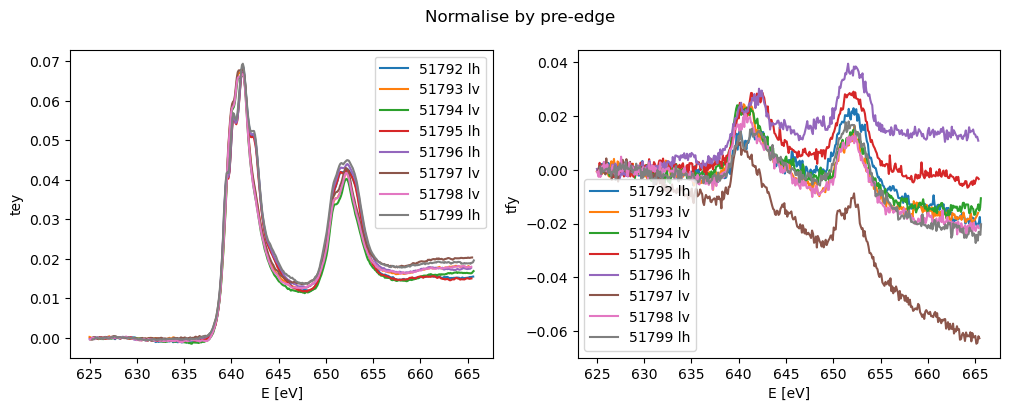

In [7]:
# Plot all spectra after normalisation and background subtraction
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
fig.suptitle('Normalise by pre-edge')
for xas_scan in scans:
    for n, (mode, spectra) in enumerate(xas_scan.spectra.items()):
        spectra.plot(ax=axes[n], label=f"{xas_scan.name} {xas_scan.metadata.pol}")
        axes[n].set_ylabel(mode)

for ax in axes.flat:
    ax.set_xlabel('E [eV]')
    ax.legend()

fig.savefig('/tmp/xas_scans.png')

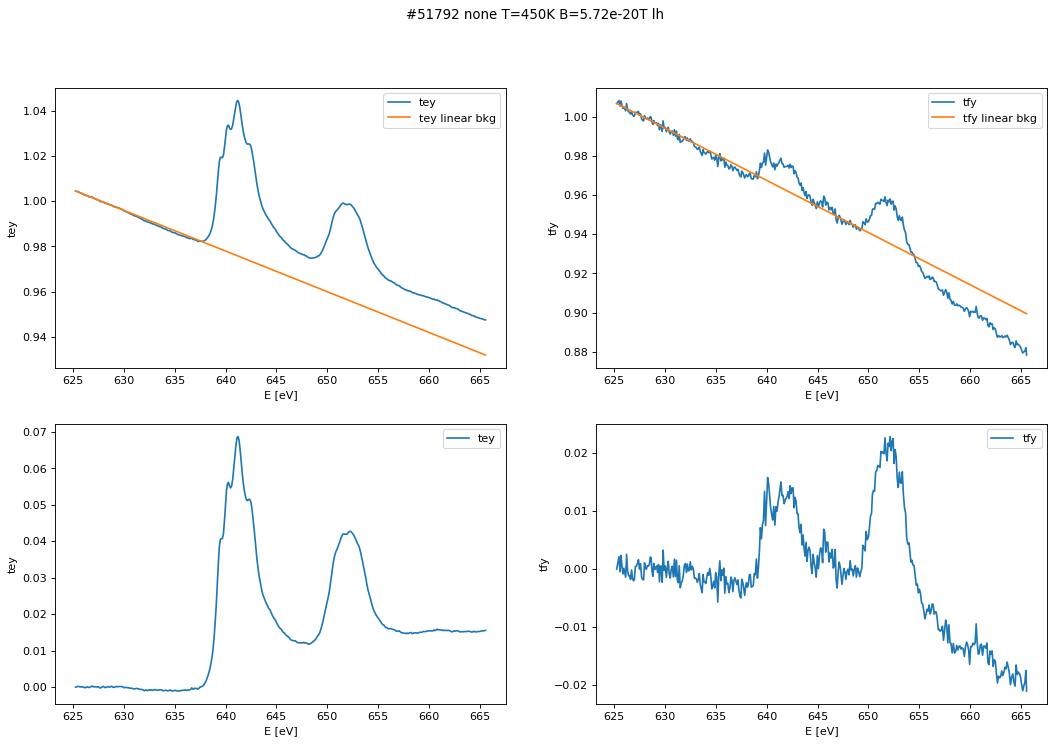

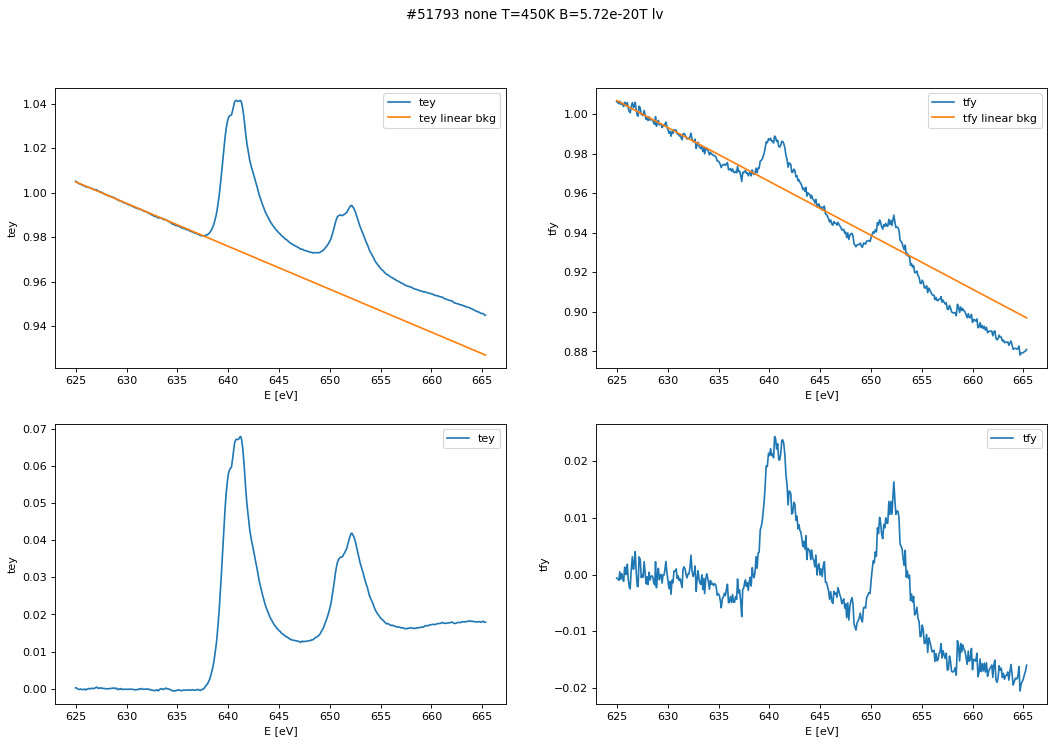

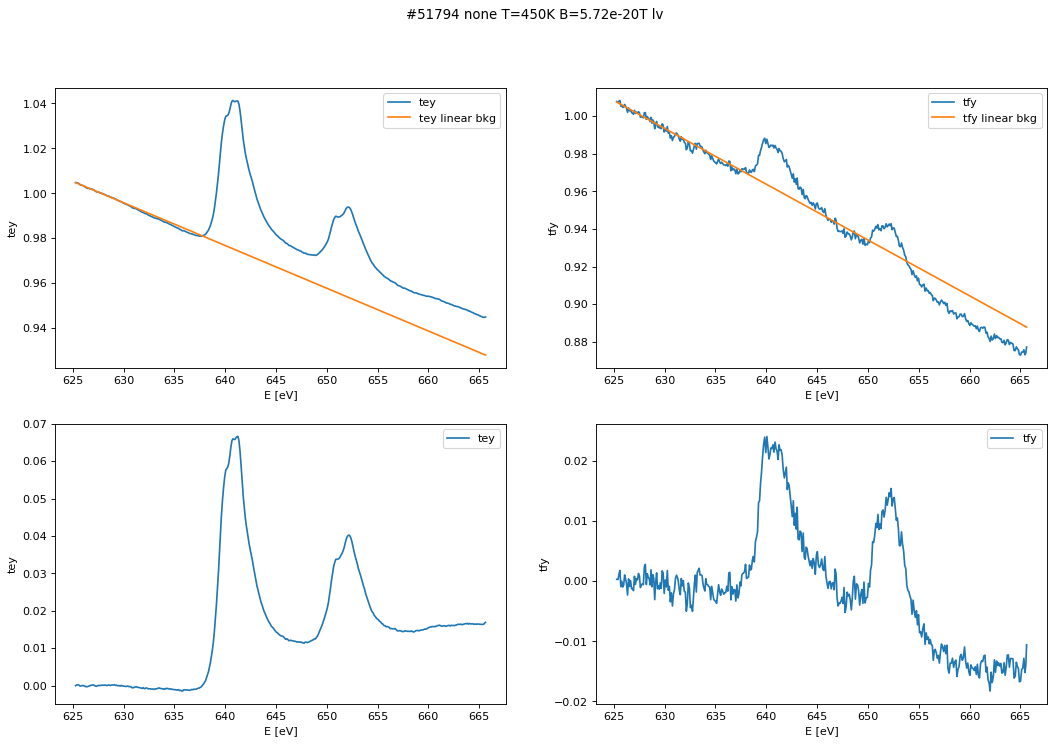

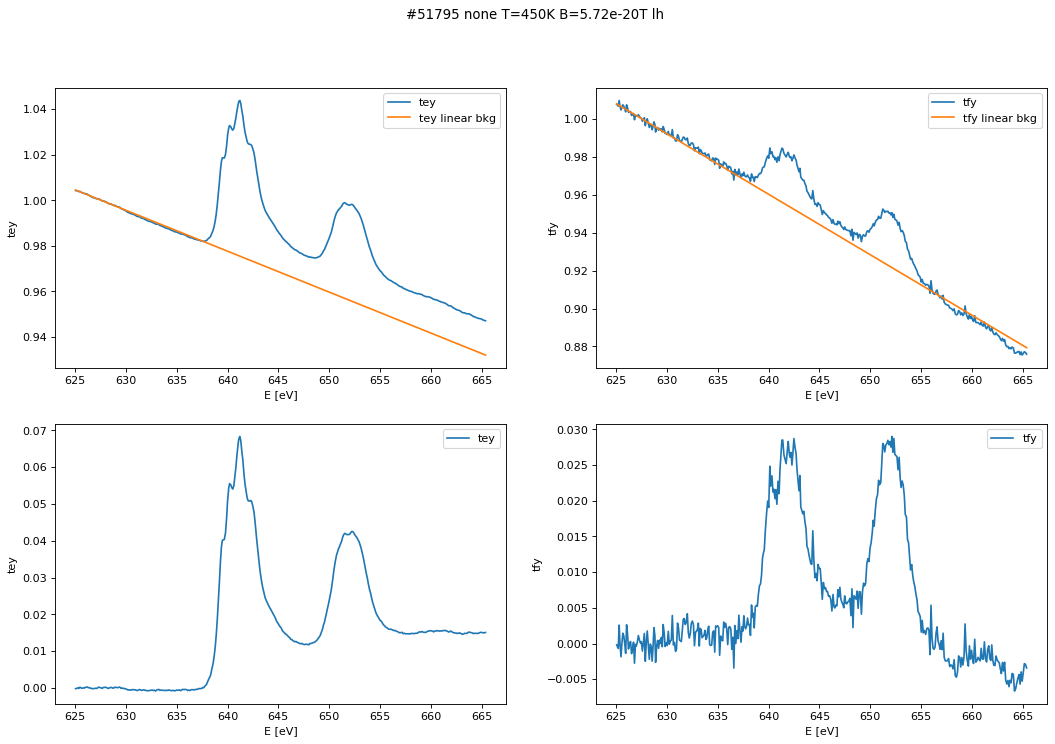

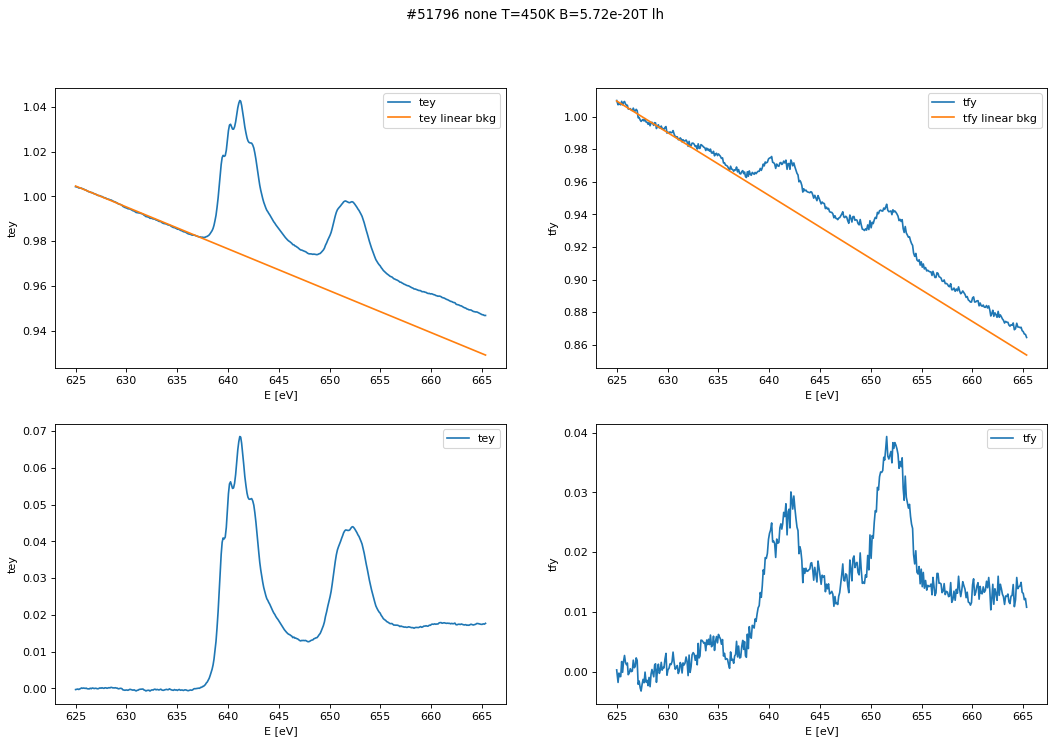

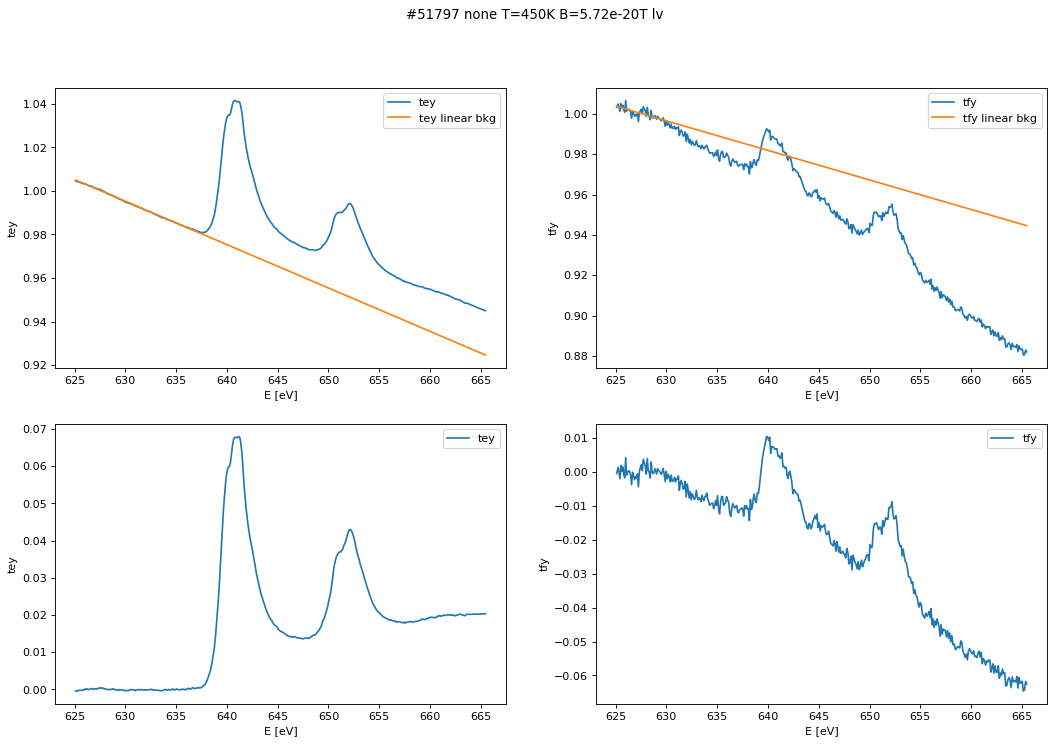

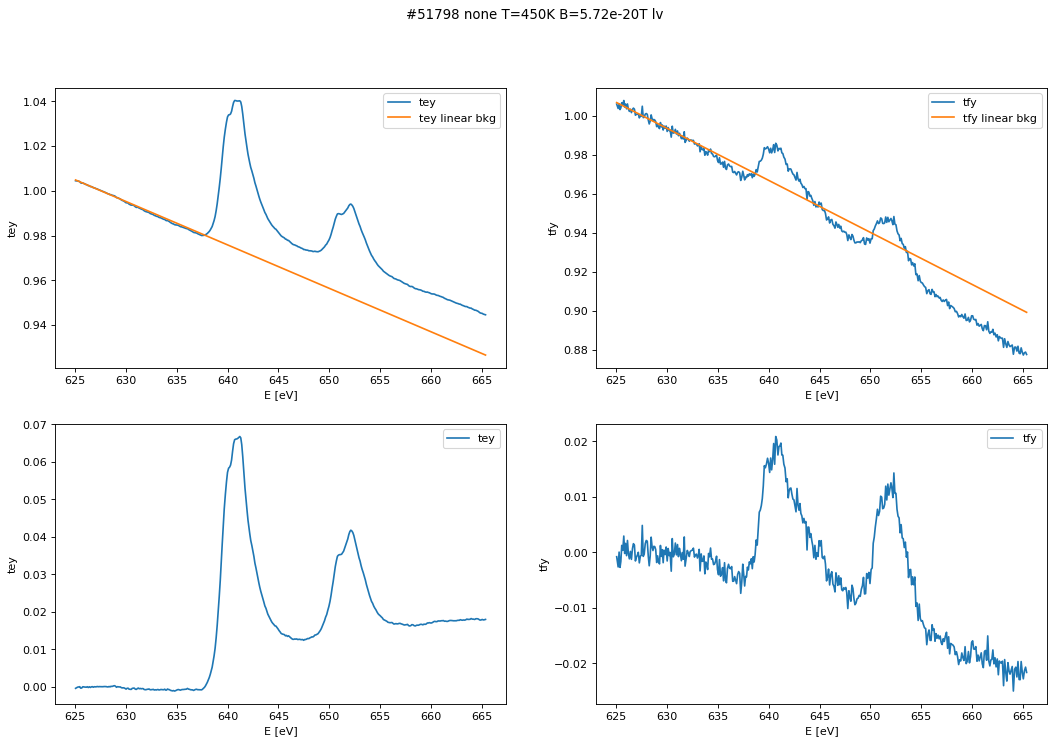

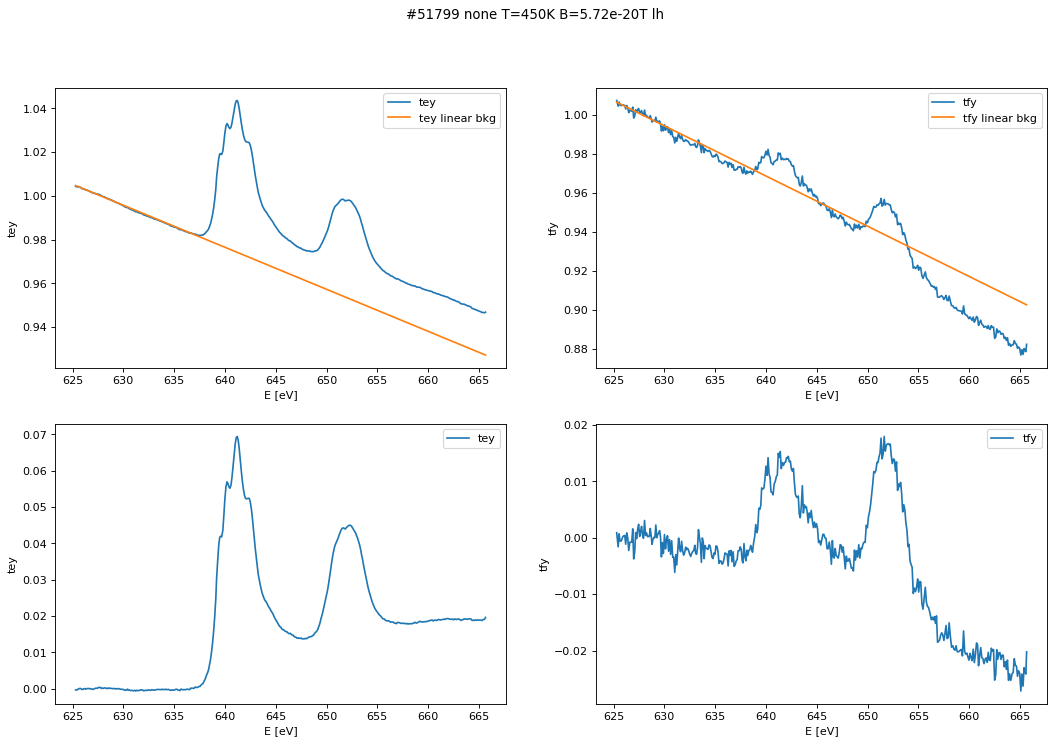

In [8]:
# Plot background subtracted scans
for xas_scan in scans:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=80)
    scan_title = f"#{xas_scan.metadata.scan_no} {edge_label} T={xas_scan.metadata.temp:.0f}K B={xas_scan.metadata.mag_field:.3g}T {xas_scan.metadata.pol}"
    fig.suptitle(scan_title)
    for n, (mode, spectra) in enumerate(xas_scan.spectra.items()):
        spectra.plot_parents(ax=axes[0, n])
        spectra.plot_bkg(ax=axes[0, n])
        axes[0, n].set_ylabel(mode)

        spectra.plot(ax=axes[1, n], label=mode)
        axes[1, n].set_ylabel(mode)

    for ax in axes.flat:
        ax.set_xlabel('E [eV]')
        ax.legend()


Averaged polarisations:
lv [51793, 51793, 51793, 51793, 51793]
lh [51792, 51792, 51792, 51792, 51792]


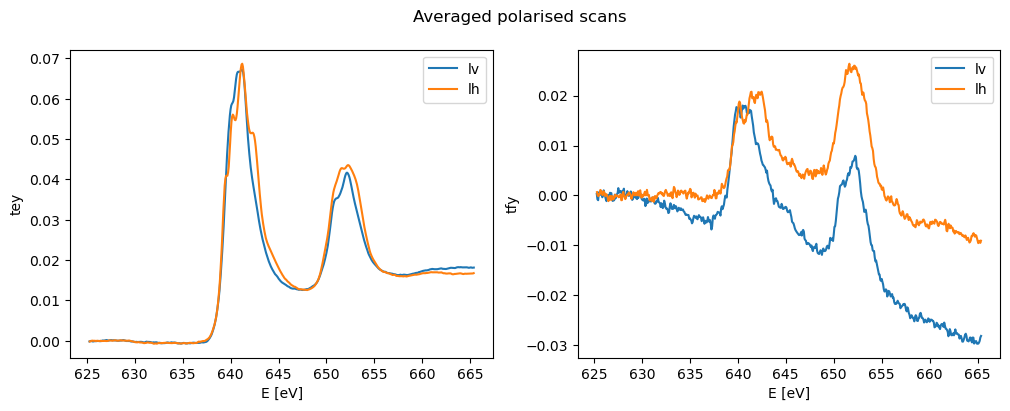

In [9]:
# Average polarised scans
av_pol_scans = average_polarised_scans(*scans)
print('Averaged polarisations:')
for av_pol in av_pol_scans:
    print(av_pol.metadata.pol, [int(parent.metadata.scan_no) for parent in av_pol.parents])

# Plot averaged scans
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
fig.suptitle('Averaged polarised scans')
for av_pol in av_pol_scans:
    for n, (mode, spectra) in enumerate(av_pol.spectra.items()):
        spectra.plot(ax=axes[n], label=av_pol.name)
        axes[n].set_ylabel(mode)

for ax in axes.flat:
    ax.set_xlabel('E [eV]')
    ax.legend()

fig.savefig('/tmp/xas_average.png')


# Calculate XMCD/XMLD

In [11]:
if len(av_pol_scans) == 2:
    pol1, pol2 = av_pol_scans
    print('Averaged polarisation scans:')
    for av_pol in av_pol_scans:
        print(av_pol.metadata.pol, [int(parent.metadata.scan_no) for parent in av_pol.parents])
    print('Subtracted polarisations:')
    xmd = pol1 - pol2
    print(f"{xmd.name.upper()} = {pol1.name} - {pol2.name}")

    print("\nSum rules reports for each spectra:")
    for name, spectra in xmd.spectra.items():
        print(f"\n{xmd.metadata.element} {xmd.metadata.edge} {xmd.name.upper()} {name}")
        print(spectra)
        print(spectra.process)
        print("Sum Rules:")
        print(spectra.sum_rules_report(float(n_holes), xmd.metadata.element))


Averaged polarisation scans:
lv [51793, 51793, 51793, 51793, 51793]
lh [51792, 51792, 51792, 51792, 51792]
Subtracted polarisations:
XMLD = lv - lh

Sum rules reports for each spectra:

Mn L3, L2 XMLD tey
SpectraSubtraction('tey', energy=array(570,), signal=array(570,),process_label='subtraction')
Subtraction of spectra S1 - S2:
  S1: SpectraAverage('tey', energy=array(554,), signal=array(554,),process_label='average_lv')
  S2: SpectraAverage('tey', energy=array(570,), signal=array(570,),process_label='average_lh')
Sum Rules:
Mn n_holes = 1.0
L = 0.087 μB
S = 0.039 μB

Mn L3, L2 XMLD tfy
SpectraSubtraction('tfy', energy=array(570,), signal=array(570,),process_label='subtraction')
Subtraction of spectra S1 - S2:
  S1: SpectraAverage('tfy', energy=array(554,), signal=array(554,),process_label='average_lv')
  S2: SpectraAverage('tfy', energy=array(570,), signal=array(570,),process_label='average_lh')
Sum Rules:
Mn n_holes = 1.0
L = -12.016 μB
S = 4.848 μB


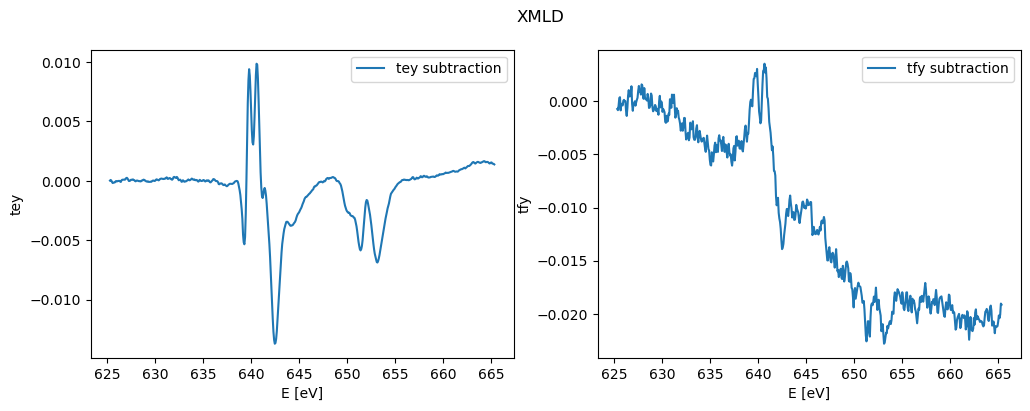

In [12]:
if len(av_pol_scans) == 2:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
    fig.suptitle(xmd.name.upper())
    for n, (mode, spectra) in enumerate(xmd.spectra.items()):
        spectra.plot(ax=axes[n])
        axes[n].set_ylabel(mode)

    for ax in axes.flat:
        ax.set_xlabel('E [eV]')
        ax.legend()

    fig.savefig('/tmp/xmcd.png')

## Save Data

In [13]:
# Averaged data
for av_pol in av_pol_scans:
    scan_nos = [int(parent.metadata.scan_no) for parent in av_pol.parents]
    file_title = f"wf_{scan_nos[0]}-{scan_nos[-1]}_{av_pol.metadata.pol}"
    # Nexus file
    nexus_filename = os.path.join(processing_directory, file_title + '.nxs')
    av_pol.write_nexus(nexus_filename)
    # CSV files
    for name, spectra in av_pol.spectra.items():
        spectra_filename = os.path.join(processing_directory, file_title + f'_{name}.csv')
        header = f"Averaged spectra from scans {scan_nos} in polarisation {av_pol.metadata.pol} in mode: {name}\nenergy [eV], signal"
        array = spectra.energy, spectra.signal
        np.savetxt(spectra_filename, array, delimiter=',', header=header)
        print(f"Saved {spectra_filename}")

# XMCD/XMLD data
if len(av_pol_scans) == 2:
    file_title = f"wf_{scans[0].metadata.scan_no}-{scans[-1].metadata.scan_no}_{xmd.name}"
    # Nexus file
    nexus_filename = os.path.join(processing_directory, file_title + '.nxs')
    xmd.write_nexus(nexus_filename)
    # CSV files
    for name, spectra in xmd.spectra.items():
        spectra_filename = os.path.join(processing_directory, file_title + f'_{name}.csv')
        header = f"{xmd.name} spectra from scans {scan_numbers} in mode: {name}\nenergy [eV], signal"
        array = spectra.energy, spectra.signal
        np.savetxt(spectra_filename, array, delimiter=',', header=header)
        print(f"Saved {spectra_filename}")

Created /dls/i10-1/data/2026/cm44154-1/processing/wf_51793-51793_lv.nxs
Saved /dls/i10-1/data/2026/cm44154-1/processing/wf_51793-51793_lv_tey.csv
Saved /dls/i10-1/data/2026/cm44154-1/processing/wf_51793-51793_lv_tfy.csv
Created /dls/i10-1/data/2026/cm44154-1/processing/wf_51792-51792_lh.nxs
Saved /dls/i10-1/data/2026/cm44154-1/processing/wf_51792-51792_lh_tey.csv
Saved /dls/i10-1/data/2026/cm44154-1/processing/wf_51792-51792_lh_tfy.csv
Created /dls/i10-1/data/2026/cm44154-1/processing/wf_51792-51799_xmld.nxs
Saved /dls/i10-1/data/2026/cm44154-1/processing/wf_51792-51799_xmld_tey.csv
Saved /dls/i10-1/data/2026/cm44154-1/processing/wf_51792-51799_xmld_tfy.csv
